In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import new_alg_v1 as na
import new_alg_v2 as na2
from tqdm import tqdm
import matplotlib.pyplot as plt
# MNIST dataset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

In [2]:
def define_dataloaders(n_examples_train, n_examples_test, batch_size, classes=np.arange(10), zscore_images=True):
    # MNIST data, batch training
    #batch_size = n_examples_train

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                  ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=n_examples_test, shuffle=False, num_workers=0)

    return trainloader, testloader

## Settings:
- no dropout
- no momentum
- increased number of fetures/filters

In [3]:
momentum = 0
n_epochs = 100
log_interval = 10

In [4]:
#Building the Network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, bias=False)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, bias=False)
        self.fc1 = nn.Linear(320, 50, bias=False)
        self.fc2 = nn.Linear(50, 10, bias=False)

    def forward(self, x):
        x = torch.tanh(F.max_pool2d(self.conv1(x), 2))
        x = torch.tanh(F.max_pool2d((self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
data_dir = '/files/'
batch_size = 1
n_examples_train = 1024
n_examples_test = 1024
train_loader, test_loader =  define_dataloaders(n_examples_train, n_examples_test, batch_size)

In [6]:
def single_batch_train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = loss_f(output,target)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    break

In [7]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_f(output,target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader)
  test_losses.append(test_loss)

# lr = 0.01

In [8]:
learning_rate = 0.01
network = Net()
optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

train_losses = []
test_losses = []

conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()

test()
single_batch_train()
test()

conv1_final = network.conv1.weight.clone()
conv2_final = network.conv2.weight.clone()
fc1_final = network.fc1.weight.clone()
fc2_final = network.fc2.weight.clone()

#init weights conv1
with torch.no_grad():
  network.conv1.weight[:] = conv1_init

test()
loss_conv1 = test_losses[-1]

#init weights conv2
with torch.no_grad():
  network.conv1.weight[:] = conv1_final
  network.conv2.weight[:] = conv2_init

test()
loss_conv2 = test_losses[-1]

#init weights fc1
with torch.no_grad():
  network.conv2.weight[:] = conv2_final
  network.fc1.weight[:] = fc1_init

test()
loss_fc1 = test_losses[-1]

#init weights fc2
with torch.no_grad():
  network.fc1.weight[:] = fc1_final
  network.fc2.weight[:] = fc2_init

test()
loss_fc2 = test_losses[-1]


IL = test_losses[0]
FL = test_losses[1]
print("inital loss = ", float(IL))
print("after one batch = ", float(FL))



inital loss =  2.299668550491333
after one batch =  2.3098104000091553


# $\chi_l$

In [9]:
dL = FL - IL
Xl1 = (FL - loss_conv1)/dL
Xl2 = (FL-loss_conv2)/dL
Xl3 = (FL-loss_fc1)/dL
Xl4 = (FL-loss_fc2)/dL
print("Xl1 = ", float(Xl1))
print("Xl2 = ", float(Xl2))
print("Xl3 = ", float(Xl3))
print("Xl4 = ", float(Xl4))

Xl1 =  0.3683294951915741
Xl2 =  0.4725186824798584
Xl3 =  0.6582584977149963
Xl4 =  0.5561380386352539


# lr = 0.005

In [10]:
learning_rate = 0.005
network = Net()
optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

train_losses = []
test_losses = []

conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()

test()
single_batch_train()
test()

conv1_final = network.conv1.weight.clone()
conv2_final = network.conv2.weight.clone()
fc1_final = network.fc1.weight.clone()
fc2_final = network.fc2.weight.clone()

#init weights conv1
with torch.no_grad():
  network.conv1.weight[:] = conv1_init

test()
loss_conv1 = test_losses[-1]

#init weights conv2
with torch.no_grad():
  network.conv1.weight[:] = conv1_final
  network.conv2.weight[:] = conv2_init

test()
loss_conv2 = test_losses[-1]

#init weights fc1
with torch.no_grad():
  network.conv2.weight[:] = conv2_final
  network.fc1.weight[:] = fc1_init

test()
loss_fc1 = test_losses[-1]

#init weights fc2
with torch.no_grad():
  network.fc1.weight[:] = fc1_final
  network.fc2.weight[:] = fc2_init

test()
loss_fc2 = test_losses[-1]

IL = test_losses[0]
FL = test_losses[1]
print("inital loss = ", float(IL))
print("after one batch = ", float(FL))



inital loss =  2.2989132404327393
after one batch =  2.3022348880767822


# $\chi_l$

In [11]:
dL = FL - IL
Xl1 = (FL - loss_conv1)/dL
Xl2 = (FL-loss_conv2)/dL
Xl3 = (FL-loss_fc1)/dL
Xl4 = (FL-loss_fc2)/dL
print("Xl1 = ", float(Xl1))
print("Xl2 = ", float(Xl2))
print("Xl3 = ", float(Xl3))
print("Xl4 = ", float(Xl4))

Xl1 =  0.5442147850990295
Xl2 =  0.3392908275127411
Xl3 =  0.26500144600868225
Xl4 =  0.17312660813331604


In [12]:
lrs = np.logspace(-2,-8,20)
n_lr = len(lrs)
Xs = np.zeros((n_lr, 4))

for i_l, lr in enumerate(lrs):
  learning_rate = lr
  network = Net()
  optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
  loss_f=nn.CrossEntropyLoss()

  train_losses = []
  test_losses = []

  conv1_init = network.conv1.weight.clone()
  conv2_init = network.conv2.weight.clone()
  fc1_init = network.fc1.weight.clone()
  fc2_init = network.fc2.weight.clone()

  test()
  single_batch_train()
  test()

  conv1_final = network.conv1.weight.clone()
  conv2_final = network.conv2.weight.clone()
  fc1_final = network.fc1.weight.clone()
  fc2_final = network.fc2.weight.clone()

  #init weights conv1
  with torch.no_grad():
    network.conv1.weight[:] = conv1_init

  test()
  loss_conv1 = test_losses[-1]

  #init weights conv2
  with torch.no_grad():
    network.conv1.weight[:] = conv1_final
    network.conv2.weight[:] = conv2_init

  test()
  loss_conv2 = test_losses[-1]

  #init weights fc1
  with torch.no_grad():
    network.conv2.weight[:] = conv2_final
    network.fc1.weight[:] = fc1_init

  test()
  loss_fc1 = test_losses[-1]

  #init weights fc2
  with torch.no_grad():
    network.fc1.weight[:] = fc1_final
    network.fc2.weight[:] = fc2_init

  test()
  loss_fc2 = test_losses[-1]


  IL = test_losses[0]
  FL = test_losses[1]


  dL = FL - IL
  Xl1 = (FL - loss_conv1)/dL
  Xl2 = (FL-loss_conv2)/dL
  Xl3 = (FL-loss_fc1)/dL
  Xl4 = (FL-loss_fc2)/dL
  Xs[i_l] = Xl1, Xl2, Xl3, Xl4


(0.0, 14.278055095672608)

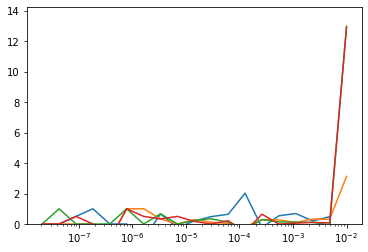

In [13]:
dX = np.abs(Xs - 1/4)
plt.plot(lrs, Xs)
plt.xscale('log')
plt.ylim(0, None)

# lr = 0.001

In [14]:
dict(network.named_parameters()).keys()

dict_keys(['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight'])

In [15]:
learning_rate = 0.001
network = Net()
optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

train_losses = []
test_losses = []

conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()

test()
single_batch_train()
test()

conv1_final = network.conv1.weight.clone()
conv2_final = network.conv2.weight.clone()
fc1_final = network.fc1.weight.clone()
fc2_final = network.fc2.weight.clone()

#init weights conv1
with torch.no_grad():
  network.conv1.weight[:] = conv1_init

test()
loss_conv1 = test_losses[-1]

#init weights conv2
with torch.no_grad():
  network.conv1.weight[:] = conv1_final
  network.conv2.weight[:] = conv2_init

test()
loss_conv2 = test_losses[-1]

#init weights fc1
with torch.no_grad():
  network.conv2.weight[:] = conv2_final
  network.fc1.weight[:] = fc1_init

test()
loss_fc1 = test_losses[-1]

#init weights fc2
with torch.no_grad():
  network.fc1.weight[:] = fc1_final
  network.fc2.weight[:] = fc2_init

test()
loss_fc2 = test_losses[-1]

IL = test_losses[0]
FL = test_losses[1]
print("inital loss = ", float(IL))
print("after one batch = ", float(FL))



inital loss =  2.305448293685913
after one batch =  2.305149555206299


# $\chi_l$

In [16]:
dL = FL - IL
Xl1 = (FL - loss_conv1)/dL
Xl2 = (FL-loss_conv2)/dL
Xl3 = (FL-loss_fc1)/dL
Xl4 = (FL-loss_fc2)/dL
print("Xl1 = ", float(Xl1))
print("Xl2 = ", float(Xl2))
print("Xl3 = ", float(Xl3))
print("Xl4 = ", float(Xl4))

Xl1 =  -0.4429369568824768
Xl2 =  0.27374300360679626
Xl3 =  0.5027933120727539
Xl4 =  0.5259377360343933


# lr = 0.0005

In [17]:
learning_rate = 0.0005
network = Net()
optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

train_losses = []
test_losses = []

conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()

test()
single_batch_train()
test()

conv1_final = network.conv1.weight.clone()
conv2_final = network.conv2.weight.clone()
fc1_final = network.fc1.weight.clone()
fc2_final = network.fc2.weight.clone()

#init weights conv1
with torch.no_grad():
  network.conv1.weight[:] = conv1_init

test()
loss_conv1 = test_losses[-1]

#init weights conv2
with torch.no_grad():
  network.conv1.weight[:] = conv1_final
  network.conv2.weight[:] = conv2_init

test()
loss_conv2 = test_losses[-1]

#init weights fc1
with torch.no_grad():
  network.conv2.weight[:] = conv2_final
  network.fc1.weight[:] = fc1_init

test()
loss_fc1 = test_losses[-1]

#init weights fc2
with torch.no_grad():
  network.fc1.weight[:] = fc1_final
  network.fc2.weight[:] = fc2_init

test()
loss_fc2 = test_losses[-1]

IL = test_losses[0]
FL = test_losses[1]
print("inital loss = ", float(IL))
print("after one batch = ", float(FL))



inital loss =  2.307868719100952
after one batch =  2.307664155960083


# $\chi_l$

In [18]:
dL = FL - IL
Xl1 = (FL - loss_conv1)/dL
Xl2 = (FL-loss_conv2)/dL
Xl3 = (FL-loss_fc1)/dL
Xl4 = (FL-loss_fc2)/dL
print("Xl1 = ", float(Xl1))
print("Xl2 = ", float(Xl2))
print("Xl3 = ", float(Xl3))
print("Xl4 = ", float(Xl4))

Xl1 =  0.21212121844291687
Xl2 =  0.308857798576355
Xl3 =  0.2482517510652542
Xl4 =  0.1818181872367859


# lr = 0.0001

In [19]:
learning_rate = 0.0001
network = Net()
optimizer = na2.new_alg(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

train_losses = []
test_losses = []

conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()

test()
single_batch_train()
test()

conv1_final = network.conv1.weight.clone()
conv2_final = network.conv2.weight.clone()
fc1_final = network.fc1.weight.clone()
fc2_final = network.fc2.weight.clone()

#init weights conv1
with torch.no_grad():
  network.conv1.weight[:] = conv1_init

test()
loss_conv1 = test_losses[-1]

#init weights conv2
with torch.no_grad():
  network.conv1.weight[:] = conv1_final
  network.conv2.weight[:] = conv2_init

test()
loss_conv2 = test_losses[-1]

#init weights fc1
with torch.no_grad():
  network.conv2.weight[:] = conv2_final
  network.fc1.weight[:] = fc1_init

test()
loss_fc1 = test_losses[-1]

#init weights fc2
with torch.no_grad():
  network.fc1.weight[:] = fc1_final
  network.fc2.weight[:] = fc2_init

test()
loss_fc2 = test_losses[-1]

IL = test_losses[0]
FL = test_losses[1]
print("inital loss = ", float(IL))
print("after one batch = ", float(FL))



inital loss =  2.290337562561035
after one batch =  2.2903664112091064


# $\chi_l$

In [20]:
dL = FL - IL
Xl1 = (FL - loss_conv1)/dL
Xl2 = (FL-loss_conv2)/dL
Xl3 = (FL-loss_fc1)/dL
Xl4 = (FL-loss_fc2)/dL
print("Xl1 = ", float(Xl1))
print("Xl2 = ", float(Xl2))
print("Xl3 = ", float(Xl3))
print("Xl4 = ", float(Xl4))

Xl1 =  1.165289282798767
Xl2 =  0.1487603336572647
Xl3 =  -0.1818181872367859
Xl4 =  -0.09917355328798294
